In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, snap
import pandas as pd
import itertools
import numpy as np
import sys

from collections import Counter
from dateutil.parser import parse as dt_parse
from matplotlib import pyplot as plt
from src.DataReader import DataReader
from src.constants import SPLIT_TIME, STORE_LOCATION, DATA_ROOT, POSTS_FILE, VOTES_FILE

In [25]:
%matplotlib inline

In [4]:
data_directory = DATA_ROOT

In [5]:
post_reader = DataReader(os.path.join(data_directory, POSTS_FILE), True)
post_reader.read_data()

Reading file...
Converting...
Progress | ██████████ | 100% || Estimated time remaining: 0.0 seconds
Conversion complete...
Forming data frame...


In [6]:
pdf = post_reader._df

In [7]:
pdf_train = pdf[pdf.CreationDate <= dt_parse(SPLIT_TIME)]

In [8]:
users_pdf = pdf_train[(pdf_train.OwnerUserId.notnull()) & (pdf_train.PostTypeId==2) ]

In [9]:
q_tags_df = pdf_train[pdf_train.PostTypeId==1][['Tags', 'Id']]

In [10]:
user_tag_df = users_pdf.merge(q_tags_df, how='left', left_on='ParentId', right_on='Id', suffixes=('_us', '_pt'))

In [11]:
user_grps = user_tag_df.groupby(['OwnerUserId'])

In [12]:
def get_user_tags(grp):
    grp_tgs = grp.Tags_pt[grp.Tags_pt.notnull()]
    return set(itertools.chain.from_iterable(grp_tgs))

In [13]:
user_tags = user_grps.apply(get_user_tags)

In [14]:
all_tags = list(set(itertools.chain.from_iterable(q_tags_df.Tags)))

In [15]:
all_tags_ids = dict(zip(all_tags, np.array(range(len(all_tags))) + 1e7))

In [16]:
user_tags_ids = user_tags.apply(lambda x: map(lambda y: all_tags_ids[y], x))

In [17]:
user_tags_ids.shape[0] + len(all_tags)

33086

In [18]:
graph = snap.TUNGraph.New()

for user, tags in user_tags_ids.iteritems():
    u = int(user)
    tgs = map(lambda x: int(x), tags)
    
    if not graph.IsNode(u):
        graph.AddNode(u)
        
    for tg in tgs:
        if not graph.IsNode(tg):
            graph.AddNode(tg)
            
        graph.AddEdge(u, tg)


In [19]:
print graph.GetEdges()
print graph.GetNodes()

368506
33065


In [20]:
DegToCntV = snap.TIntPrV()
snap.GetDegCnt(graph, DegToCntV)

deg_hist = {}
for item in DegToCntV:
    deg_hist[item.GetVal1()] = item.GetVal2()

x, y = zip(*deg_hist.items())

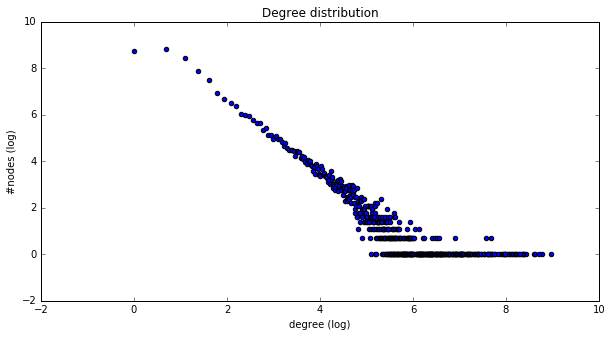

In [26]:
plt.figure(figsize=(10,5))
# ax = plt.subplot()

plt.scatter(np.log(x), np.log(y))

plt.xlabel('degree (log)')
plt.ylabel('#nodes (log)')
plt.title('Degree distribution')

plt.show()

In [27]:
snap.SaveEdgeList(graph, 'data_created/graphs/user-tag.txt', 'User-tag graph')

In [34]:
with open('data_created/graphs/user-tag_keys.txt', 'w') as fl:
    for k,v in all_tags_ids.items():
        fl.write('{0}, {1}\n'.format(k, v))